In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

# Load datasets (update paths accordingly)
sensex = pd.read_excel(r"C:\Users\Sandesh\Project\NMIMS Project\BSE Sensex Data.xlsx")
bonds = pd.read_excel(r"C:\Users\Sandesh\Project\NMIMS Project\India Bond Yeild Data.xlsx")
nifty_50 = pd.read_excel(r"C:\Users\Sandesh\Project\NMIMS Project\Nifty 50 Data.xlsx") 
gold = pd.read_excel(r"C:\Users\Sandesh\Project\NMIMS Project\Gold Rates Data.xlsx")
USD_INR = pd.read_excel(r"C:\Users\Sandesh\Project\NMIMS Project\USD_INR Data.xlsx")

# Check the structure of the datasets
print("Sensex Data:")
print(sensex.head())
print("\nBonds Data:")
print(bonds.head())
print("\nNifty 50 Data:")
print(nifty_50.head())
print("\nGold Data:")
print(gold.head())
print("\nUSD_INR Data:")
print(USD_INR.head())

# Calculate daily returns for each asset
returns = pd.DataFrame({
    'BSE': sensex['Price'].pct_change(),
    'Bonds': bonds['Price'].pct_change(),
    'Nifty50': nifty_50['Price'].pct_change(),
    'Gold': gold['Price'].pct_change(),
    'USD_INR': USD_INR['Price'].pct_change()
}).dropna()


Sensex Data:
        Date     Price      Open      High       Low  Change %
0 2024-03-01  73651.35  72606.31  74245.17  71674.42    0.0159
1 2024-02-01  72500.30  71998.78  73413.93  70809.84    0.0104
2 2024-01-01  71752.11  72218.39  73427.59  70001.60   -0.0068
3 2023-12-01  72240.26  67181.15  72484.34  67149.07    0.0784
4 2023-11-01  66988.44  63829.87  67069.89  63550.46    0.0487

Bonds Data:
        Date  Price   Open   High    Low  Change %
0 2024-03-01  7.052  7.052  7.052  7.052   -0.0037
1 2024-02-01  7.078  7.078  7.078  7.078   -0.0092
2 2024-01-01  7.144  7.207  7.239  7.134   -0.0045
3 2023-12-01  7.176  7.293  7.298  7.147   -0.0142
4 2023-11-01  7.279  7.376  7.376  7.194   -0.0098

Nifty 50 Data:
        Date     Price      Open      High      Low  Change %
0 2024-03-01  22326.90  22048.30  22526.60  21710.2    0.0157
1 2024-02-01  21982.80  21780.65  22297.50  21530.2    0.0118
2 2024-01-01  21725.70  21727.75  22124.15  21137.2   -0.0003
3 2023-12-01  21731.40  20

Covariance Matrix:
              BSE     Bonds   Nifty50      Gold   USD_INR
BSE      0.002405  0.000108  0.002412  0.000024 -0.000365
Bonds    0.000108  0.000657  0.000106 -0.000053  0.000049
Nifty50  0.002412  0.000106  0.002435  0.000026 -0.000371
Gold     0.000024 -0.000053  0.000026  0.001530 -0.000121
USD_INR -0.000365  0.000049 -0.000371 -0.000121  0.000220


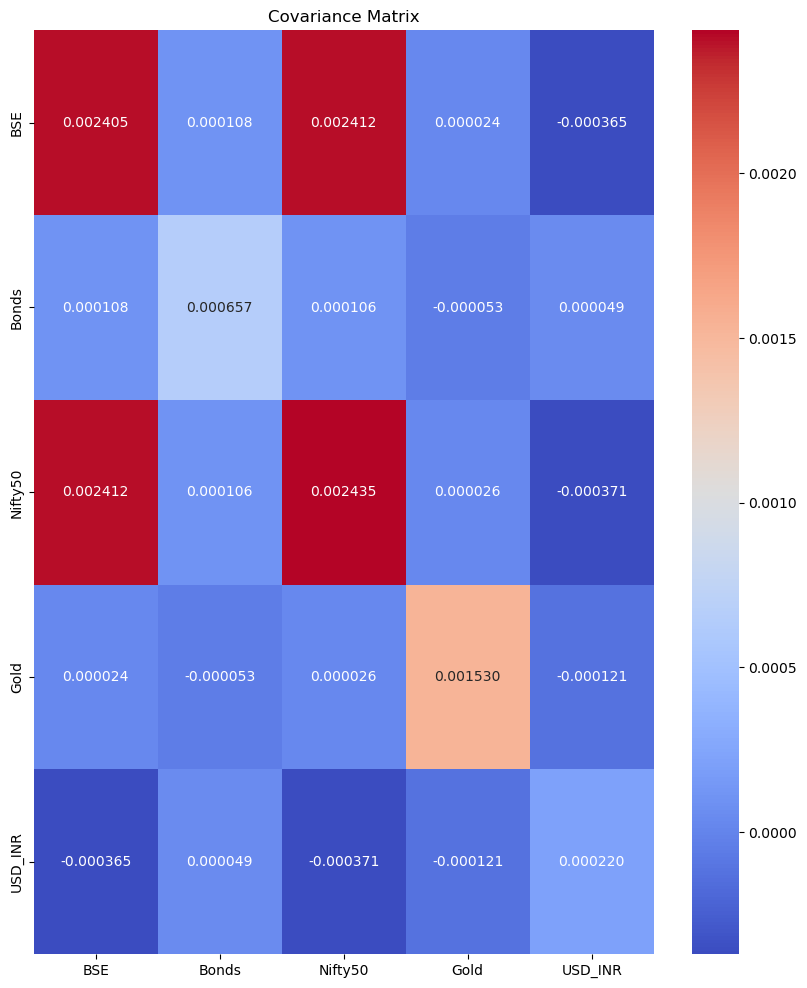

In [6]:
# Calculate the covariance matrix
cov_matrix = returns.cov()

# Display covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

# Plot the covariance matrix for better visualization
plt.figure(figsize=(10,12))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".6f")
plt.title('Covariance Matrix')
plt.show()

In [7]:
scaler = StandardScaler()
scaled_assets = scaler.fit_transform(assets)

In [8]:
# Apply PCA
pca = PCA()
pca.fit(scaled_assets)

# Get explained variance ratios and components
explained_variance = pca.explained_variance_ratio_
components = pca.components_

# Display explained variance ratios
print("Explained Variance Ratios:", explained_variance)

Explained Variance Ratios: [0.47592446 0.23282411 0.18758691 0.1030039  0.00066062]


In [9]:
# Calculate Effective Number of Bets (ENB)
def calculate_enb(explained_variance):
    E = np.sum(explained_variance)  # Total explained variance
    enb = 1 / np.sum((explained_variance / E) ** 2)  # ENB calculation
    return enb

enb = calculate_enb(explained_variance)
print("Effective Number of Bets (ENB):", enb)

Effective Number of Bets (ENB): 3.0626910002597683


In [10]:
# Objective function to balance risk contributions across principal components
def risk_balance_objective(weights, components, explained_variance):
    # Calculate portfolio risk contributions for each component
    portfolio_risk_contribs = np.dot(weights, components.T) ** 2 * explained_variance
    # Normalize risk contributions
    total_risk = np.sum(portfolio_risk_contribs)
    target_contrib = total_risk / len(explained_variance)  # Equal contribution target
    # Minimize deviation from the target contribution
    return np.sum((portfolio_risk_contribs - target_contrib) ** 2)

In [11]:
# Initial weights (equal allocation across components)
initial_weights = np.array([1 / len(explained_variance)] * len(explained_variance))

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1
bounds = [(0, 1) for _ in range(len(explained_variance))]  # Weights between 0 and 1

# Optimization
result = minimize(risk_balance_objective, initial_weights, args=(components, explained_variance), bounds=bounds, constraints=constraints)

# Optimized weights for PCRBP
optimal_weights_pcrbp = result.x
print("Optimized Weights for PCRBP:", optimal_weights_pcrbp)

Optimized Weights for PCRBP: [0.19370513 0.19421129 0.19377883 0.14461104 0.27369371]


In [12]:
# Calculate risk contributions for optimized weights
def calculate_risk_contributions(weights, components, explained_variance):
    # Portfolio risk contributions by component
    risk_contribs = (weights @ components.T) ** 2 * explained_variance
    return risk_contribs

pc_risk_contributions = calculate_risk_contributions(optimal_weights_pcrbp, components, explained_variance)
print("Principal Component Risk Contributions:", pc_risk_contributions)
print("Total Portfolio Risk:", np.sqrt(np.sum(pc_risk_contributions)))

Principal Component Risk Contributions: [8.22619461e-03 8.58430792e-03 9.43914902e-03 1.07259644e-02
 3.35408937e-09]
Total Portfolio Risk: 0.1922904556372372


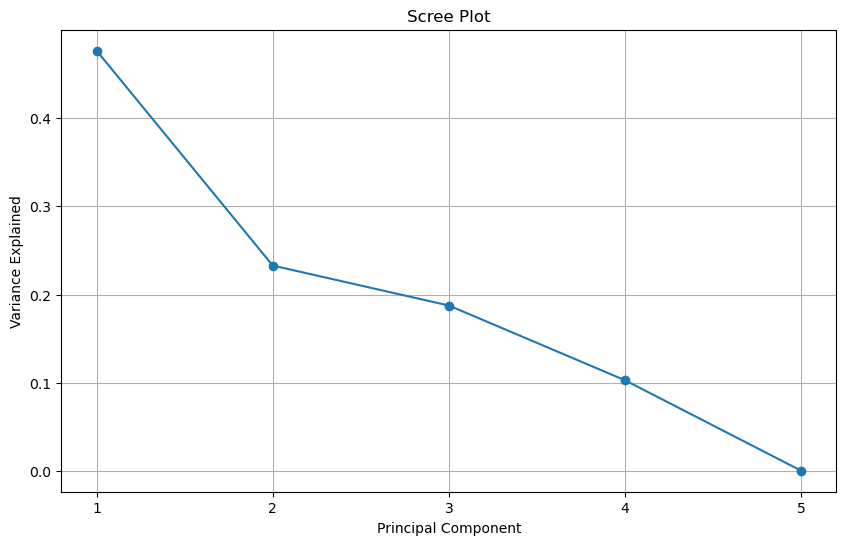

In [13]:
# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

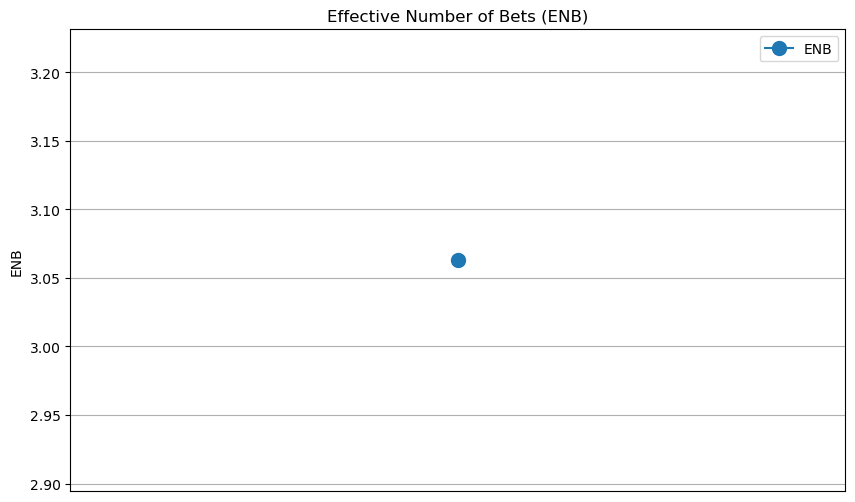

In [14]:
# ENB Visualization (for a single calculation, more complex for variations)
plt.figure(figsize=(10, 6))
plt.plot([1], [enb], marker='o', markersize=10, label='ENB')
plt.title('Effective Number of Bets (ENB)')
plt.ylabel('ENB')
plt.xticks([])
plt.legend()
plt.grid()
plt.show()

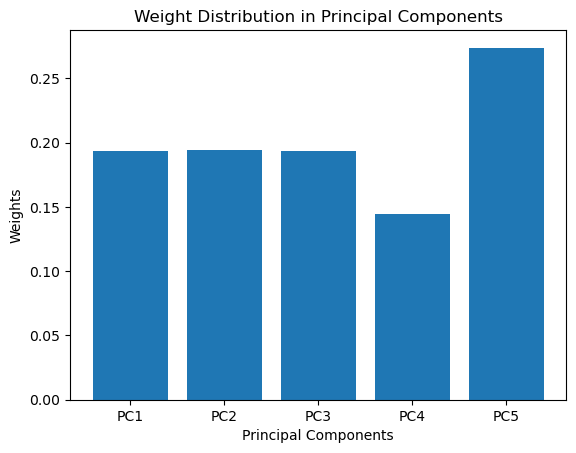

In [15]:
# Weight distribution in principal components
plt.bar(range(len(optimal_weights_pcrbp)), optimal_weights_pcrbp)
plt.title('Weight Distribution in Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Weights')
plt.xticks(range(len(optimal_weights_pcrbp)), [f'PC{i+1}' for i in range(len(optimal_weights_pcrbp))])
plt.show()

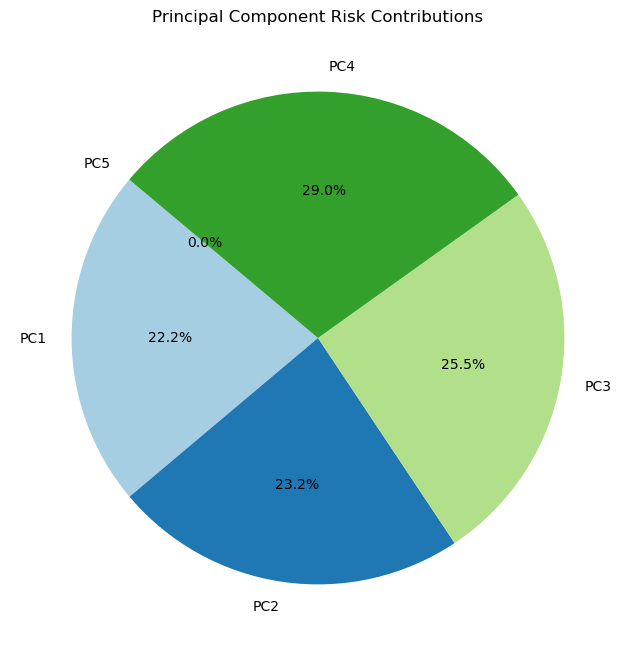

In [17]:
import matplotlib.pyplot as plt

# Assuming pc_risk_contributions is a list of risk contributions for each principal component
pc_risk_contributions = [8.22619461e-03, 8.58430792e-03, 9.43914902e-03, 1.07259644e-02, 3.35408937e-09]
num_components = len(pc_risk_contributions)

# Convert to percentages
pc_risk_contributions_percentage = [val * 100 for val in pc_risk_contributions]

# Labels for principal components
pc_labels = [f'PC{i+1}' for i in range(num_components)]

# Plotting as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(pc_risk_contributions_percentage, labels=pc_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors[:num_components])
plt.title('Principal Component Risk Contributions')
plt.show()